In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df_entire = pd.read_csv('/content/gdrive/My Drive/clean_data.csv')
df = df_entire[['text','topic']]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# tf-idf vevctorization

tfidf = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tfidf_fit = tfidf.fit(df['text'])
tv_matrix = tfidf_fit.transform(df['text'])
columns = tfidf.get_feature_names()

In [ ]:
# LDA topic modelling

lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda_matrix = lda.fit_transform(tv_matrix)
features = pd.DataFrame(lda_matrix)

##Clustering

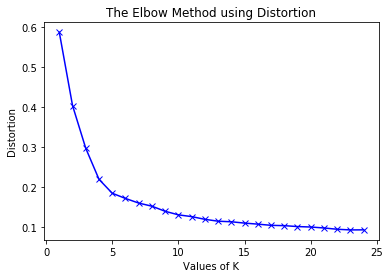

In [ ]:
# elbow method to find best n_clusters value
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K_range = range(1,25) 
  
for k in K_range: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(features) 
    kmeanModel.fit(features)     
      
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / features.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(features, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / features.shape[0] 
    mapping2[k] = kmeanModel.inertia_

plt.plot(K_range, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [ ]:
# kmeans

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(features)
pred = kmeans.predict(features)
df['clusterId'] = pred


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# checking best number of clusters using silhoutte score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_values = [3,4,5,6,7]
for cluster in cluster_values:
    cluster_labels = KMeans(n_clusters=cluster, random_state=0).fit_predict(features)
    silhouette_coeff = silhouette_score(features, cluster_labels)
    print("cluster value",cluster,"silhouette ",silhouette_coeff)
    

cluster value 3 silhouette  0.5896659901860423
cluster value 4 silhouette  0.6687588986985732
cluster value 5 silhouette  0.6037586288114895
cluster value 6 silhouette  0.5820879277117836
cluster value 7 silhouette  0.5763364139189154


## Classification for every cluster

In [ ]:
# Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

def random_forest(x_train, x_test, y_train, y_test, cluster_id):
  clf_rfc = RandomForestClassifier(n_estimators=100,random_state=1)
  clf_rfc.fit(x_train,y_train)
  pred_rfc = clf_rfc.predict(x_test)
  print("Cluster: ",cluster_id," - Random forest accuracy:",metrics.accuracy_score(y_test, pred_rfc))

In [ ]:
# runs classifiers across all the cluster
for cluster in range(0,4):
  # filter dataset based on the cluster id
  df_cluster = df.loc[df['clusterId'] == cluster]
  # split test and train data
  X_train, X_test, y_train, y_test = train_test_split(df_cluster["text"], df_cluster["topic"], test_size=0.3)
  x_train = tfidf_fit.transform(X_train)
  x_test = tfidf_fit.transform(X_test)
  # call random forest classifier
  random_forest(x_train, x_test, y_train, y_test, cluster)


Cluster:  0  - Random forest accuracy: 0.8400727578004757
Cluster:  1  - Random forest accuracy: 0.7553066037735849
Cluster:  2  - Random forest accuracy: 0.908
Cluster:  3  - Random forest accuracy: 0.8579136690647482


In [ ]:
from sklearn.svm import SVC

# runs classifiers across all the cluster
for cluster in range(0,4):
  df_cluster = df.loc[df['clusterId'] == cluster]
  X_train, X_test, y_train, y_test = train_test_split(df_cluster["text"], df_cluster["topic"], test_size=0.3)
  x_train = tfidf_fit.transform(X_train)
  x_test = tfidf_fit.transform(X_test)
  
  clf_svm = SVC(gamma='auto')
  clf_svm.fit(x_train, y_train)
  pred_svm = clf_svm.predict(x_test)
  print("Cluster: ",cluster," - SVM accuracy:",metrics.accuracy_score(y_test, pred_svm))

Cluster:  0  - SVM accuracy: 0.21869315796837835
Cluster:  1  - SVM accuracy: 0.13738207547169812
Cluster:  2  - SVM accuracy: 0.5588571428571428
Cluster:  3  - SVM accuracy: 0.306205035971223


In [ ]:
from sklearn.linear_model import LogisticRegression

for cluster in range(0,4):
  df_cluster = df.loc[df['clusterId'] == cluster]
  X_train, X_test, y_train, y_test = train_test_split(df_cluster["text"], df_cluster["topic"], test_size=0.3)
  x_train = tfidf_fit.transform(X_train)
  x_test = tfidf_fit.transform(X_test)  
  clf_lr = LogisticRegression(random_state=0).fit(x_train, y_train)
  pred_lr = clf_lr.predict(x_test)
  print("Cluster: ",cluster," - Logistic regression accuracy:",metrics.accuracy_score(y_test, pred_lr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Cluster:  0  - Logistic regression accuracy: 0.8153071218693158
Cluster:  1  - Logistic regression accuracy: 0.6801297169811321
Cluster:  2  - Logistic regression accuracy: 0.8365714285714285
Cluster:  3  - Logistic regression accuracy: 0.8156474820143885


In [ ]:
from sklearn.naive_bayes import MultinomialNB

for cluster in range(0,4):
  df_cluster = df.loc[df['clusterId'] == cluster]
  X_train, X_test, y_train, y_test = train_test_split(df_cluster["text"], df_cluster["topic"], test_size=0.3)
  x_train = tfidf_fit.transform(X_train)
  x_test = tfidf_fit.transform(X_test)
  clf_mnb = MultinomialNB().fit(x_train, y_train)
  pred_mnb = clf_mnb.predict(x_test)
  print("Cluster: ",cluster," - Multinomial NB accuracy:",metrics.accuracy_score(y_test, pred_mnb))

Cluster:  0  - Multinomial NB accuracy: 0.2739611025605149
Cluster:  1  - Multinomial NB accuracy: 0.3163325471698113
Cluster:  2  - Multinomial NB accuracy: 0.6091428571428571
Cluster:  3  - Multinomial NB accuracy: 0.36510791366906475


## Neural net

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
import pandas as pd
import numpy as np

In [ ]:
# Since we need to run clustering everytime to get the clustered dataFrame, we stored it as csv and used it to run it once the session is timedout in Google Colab

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/My Drive/cluster.csv')
df = df[['text','topic','clusterId']]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# autoEncodder.
# this function takes the dataset and extracts the feature from the dataset
def getEncodedText(X):
  ncol = X.shape[1]
  encoding_dim = 210
  input_dim = Input(shape = (ncol, ))
  encoded = Dense(encoding_dim, activation='relu')(input_dim)
  decoded = Dense(ncol, activation='sigmoid')(encoded)
  autoencoder = Model(input_dim, decoded)
  encoder = Model(input_dim, encoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  autoencoder.summary()
  autoencoder.fit(X, X,epochs=2,batch_size=256,shuffle=True,validation_data=(X, X))
  encode_test = encoder.predict(X)
  return encode_test

In [ ]:
# This function adds neural network
def addLayers(X_train, y_train):
  input_dim = X_train.shape[1]
  output_dim = y_train.shape[1]
  model = Sequential()
  model.add(layers.Dense(1000, input_dim=input_dim, activation='relu'))
  model.add(layers.Dense(500, activation='relu'))
  model.add(layers.Dense(250, activation='relu'))
  model.add(layers.Dense(output_dim, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

##5.Deep learning

After getting the features from the autoencoder, we built a deep neural net with the reduced text features and one hot encoding with the bip-topics which are the labels. The neural nets was built with input layer and four dense layers. Training the model by taking the four clusters into consideration, gave me accuracy of 88 percentage in cluster 0, by training 11306 samples. For cluster 1,cluster 2 and cluster 3 , gains an accuracy of 65 percent, 83 percent and 71 percent respectively.

In [ ]:
# this function predicts the classifier output and evaluates it.

from sklearn import metrics 
def fitAndPredict(model, X_train, y_train, X_test, y_test, cluster):
  history = model.fit(X_train, y_train, epochs=2, verbose=False, validation_data=(X_test, y_test),batch_size=100)
  y_pred = model.predict(X_test)
  y_pred_con = np.argmax(y_pred, axis=1)
  y_test_conv = np.argmax(y_test, axis=1)
  print('----------------------------------------------------------------------------------')
  print("Cluster: ",cluster,"  | NN  accuracy:",metrics.accuracy_score(y_test_conv, y_pred_con))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
vectorizer = CountVectorizer()

for cluster in range(0,4):
  sentences = df.loc[df['clusterId'] == cluster]['text'].values
  y_enc = pd.get_dummies(df.loc[df['clusterId'] == cluster]["topic"])
  vectorizer.fit(sentences)
  sentences_vect = vectorizer.transform(sentences)
  encoded_text = getEncodedText(sentences_vect)
  X_train, X_test, y_train, y_test = train_test_split(encoded_text, y_enc.values, test_size=0.3)
  model = addLayers(X_train, y_train)
  fitAndPredict(model, X_train, y_train, X_test, y_test, cluster)

Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 48966)             0         
_________________________________________________________________
dense_207 (Dense)            (None, 210)               10283070  
_________________________________________________________________
dense_208 (Dense)            (None, 48966)             10331826  
Total params: 20,614,896
Trainable params: 20,614,896
Non-trainable params: 0
_________________________________________________________________
Train on 23821 samples, validate on 23821 samples
Epoch 1/2
23821/23821 [==============================] - 181s 8ms/step - loss: 0.1174 - acc: 0.9826 - val_loss: 0.0197 - val_acc: 0.9976
Epoch 2/2
23821/23821 [==============================] - 177s 7ms/step - loss: 0.0187 - acc: 0.9976 - val_loss: 0.0179 - val_acc: 0.9975
Model: "sequential_29"
_____________________________